### Generate data with the general dataset from VRS 
Format of general dataset
```
ucl_east/
    seq/
        000000.color.png
        000000.depth.png (mm)
        000000.semantic.png
    poses.txt (TUM format: timestamp tx ty tz qx qy qz qw)
    intrinsics.txt (format: fx fy cx cy width height)
```

#### Pipeline:
1. Load the VRS file
2. Load the MPS trajectory
3. Read through all images
4. For each image, find the nearest pose of the image, compute the pose of the camera, rotate image, and save
5. Save poses and intrinsics to files

In [1]:
import os
from projectaria_tools.core import data_provider, calibration
from projectaria_tools.core.sensor_data import TimeDomain, TimeQueryOptions
from projectaria_tools.core.stream_id import RecordableTypeId, StreamId
from projectaria_tools.core.mps.utils import get_nearest_pose
import projectaria_tools.core.mps as mps
from projectaria_tools.core.sophus import SO3, SE3, interpolate, iterativeMean
import numpy as np
import copy
from PIL import Image

from matplotlib import pyplot as plt
data_path = "/Rocket_ssd/dataset/data_topo_loc/ucl_campus/vloc_ops_lab"
# Input data
vrsfile = os.path.join(data_path, "ops_lab_vrs/ops_lab.vrs")
open_traj_file = os.path.join(data_path, "ops_lab_vrs/mps_ops_lab_vrs/slam/open_loop_trajectory.csv")
closed_traj_file = os.path.join(data_path, "ops_lab_vrs/mps_ops_lab_vrs/slam/closed_loop_trajectory.csv")
# Output data
out_dir = os.path.join(data_path, "out_general")
os.makedirs(out_dir, exist_ok=True)
os.makedirs(os.path.join(out_dir, "seq"), exist_ok=True)

In [2]:
# Load VRS file
provider = data_provider.create_vrs_data_provider(vrsfile)
assert provider is not None, "Cannot open file"
# Load trajectories
open_loop_traj = mps.read_open_loop_trajectory(open_traj_file)
closed_loop_traj = mps.read_closed_loop_trajectory(closed_traj_file)

[ProgressLogger][INFO]: 2024-08-31 23:58:54: Opening /Rocket_ssd/dataset/data_topo_loc/ucl_campus/vloc_ops_lab/ops_lab_vrs/ops_lab.vrs...
[VRSIndexRecord][WARNING]: 12 record(s) not sorted properly. Sorting index.
[MultiRecordFileReader][DEBUG]: Opened file '/Rocket_ssd/dataset/data_topo_loc/ucl_campus/vloc_ops_lab/ops_lab_vrs/ops_lab.vrs' and assigned to reader #0
[VrsDataProvider][INFO]: streamId 214-1/camera-rgb activated
[VrsDataProvider][INFO]: streamId 247-1/baro0 activated
[VrsDataProvider][INFO]: streamId 281-1/gps activated
[VrsDataProvider][INFO]: streamId 282-1/wps activated
[VrsDataProvider][INFO]: streamId 283-1/bluetooth activated
[VrsDataProvider][WARNING]: Unsupported TimeSync mode: APP, ignoring.
[VrsDataProvider][INFO]: Fail to activate streamId 286-1
[VrsDataProvider][INFO]: streamId 1201-1/camera-slam-left activated
[VrsDataProvider][INFO]: streamId 1201-2/camera-slam-right activated
[VrsDataProvider][INFO]: streamId 1202-1/imu-right activated
[VrsDataProvider][INFO

Loaded #open loop trajectory poses records: 127164
Loaded #closed loop trajectory poses records: 125514


In [3]:
flag_debug = False
# Initialize parameters
poses = np.zeros((0, 8))
intrinsics = np.zeros((0, 6))
img_save_idx = 0
# Set a initial pose
T_ini = SE3().from_matrix(np.eye(4, 4))
init_pose = False
# Load image
camera_label = "camera-rgb"
stream_id = provider.get_stream_id_from_label(camera_label)
num_data = provider.get_num_data(stream_id)
print(f"Stream ID (camera-rgb): {stream_id} with {num_data} data")
for index in range(0, num_data):
    img_data = provider.get_image_data_by_index(stream_id, index)
    img_timestamp = img_data[1].capture_timestamp_ns
    # print(f"Get image data at index {index} with timestamp {img_timestamp}")

    raw_calib = provider.get_device_calibration().get_camera_calib(camera_label)
    focal_length = raw_calib.get_focal_lengths()
    principal_point = raw_calib.get_principal_point()
    image_size = raw_calib.get_image_size() # width, height
    
    pinhole = calibration.get_linear_camera_calibration(
        image_size[0], image_size[1], focal_length[0], camera_label, raw_calib.get_transform_device_camera())
    raw_image = img_data[0].to_numpy_array()
    undistorted_image = calibration.distort_by_calibration(raw_image, pinhole, raw_calib)
    
    rotated_image = np.rot90(undistorted_image, k=3)
    pinhole_cw90 = calibration.rotate_camera_calib_cw90deg(pinhole)
    focal_length = pinhole_cw90.get_focal_lengths()
    principal_point = pinhole_cw90.get_principal_point()
    image_size = pinhole_cw90.get_image_size()

    if flag_debug:
        plt.figure(figsize=(15,5))
        plt.subplot(1, 3, 1)
        plt.imshow(raw_image, cmap='gray', vmin=0, vmax=255)
        plt.title("Raw image")
        plt.axis('off')
        plt.subplot(1, 3, 2)
        plt.imshow(undistorted_image, cmap='gray', vmin=0, vmax=255)
        plt.title("Undistorted image")
        plt.axis('off')
        plt.subplot(1, 3, 3)
        plt.imshow(rotated_image, cmap='gray', vmin=0, vmax=255)
        plt.title("Rotated image")
        plt.axis('off')
        plt.show()        

    pose_info = get_nearest_pose(closed_loop_traj, img_timestamp)
    if pose_info:
        T_world_device = pose_info.transform_world_device
        T_device_rgb_camera = pinhole_cw90.get_transform_device_camera()
        T_world_rgb_camera = T_world_device @ T_device_rgb_camera
        if not init_pose:
            T_ini = T_world_rgb_camera
            init_pose = True
        T_world_rgb_camera_rgb_camera = T_ini.inverse() @ T_world_rgb_camera

        vec = T_world_rgb_camera_rgb_camera.to_quat_and_translation()
        quat_wxyz, trans = vec[0, :4], vec[0, 4:]
        pose = np.array([img_timestamp/1e9, 
                         trans[0], trans[1], trans[2], 
                         quat_wxyz[1], quat_wxyz[2], quat_wxyz[3], quat_wxyz[0]])
        poses = np.vstack((poses, pose))
        intrinsic = np.array([focal_length[0], focal_length[1], 
                              principal_point[0], principal_point[1], 
                              image_size[0], image_size[1]])
        intrinsics = np.vstack((intrinsics, intrinsic))
        
        image_pil = Image.fromarray(rotated_image.astype(np.uint8))
        image_pil.save(os.path.join(out_dir, "seq", f"{img_save_idx:06d}.color.jpg"))
        print(f"Save image {img_save_idx:05d}.color.jpg")
        img_save_idx += 1

np.savetxt(os.path.join(out_dir, "poses.txt"), poses, fmt='%.9f')
np.savetxt(os.path.join(out_dir, "intrinsics.txt"), intrinsics, fmt='%.9f')

Stream ID (camera-rgb): 214-1 with 1900 data
Save image 00000.color.png
Save image 00001.color.png
Save image 00002.color.png
Save image 00003.color.png
Save image 00004.color.png
Save image 00005.color.png
Save image 00006.color.png
Save image 00007.color.png
Save image 00008.color.png
Save image 00009.color.png
Save image 00010.color.png
Save image 00011.color.png
Save image 00012.color.png
Save image 00013.color.png
Save image 00014.color.png
Save image 00015.color.png
Save image 00016.color.png
Save image 00017.color.png
Save image 00018.color.png
Save image 00019.color.png
Save image 00020.color.png
Save image 00021.color.png
Save image 00022.color.png
Save image 00023.color.png
Save image 00024.color.png
Save image 00025.color.png
Save image 00026.color.png
Save image 00027.color.png
Save image 00028.color.png
Save image 00029.color.png
Save image 00030.color.png
Save image 00031.color.png
Save image 00032.color.png
Save image 00033.color.png
Save image 00034.color.png
Save image

### Visualize Poses

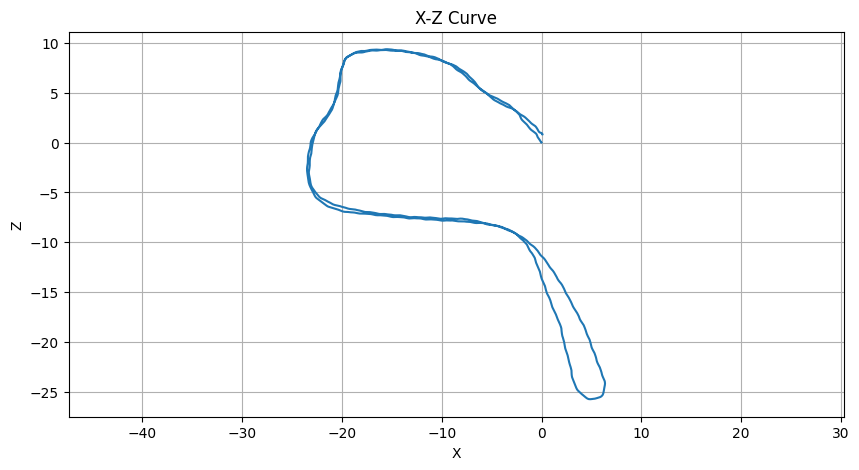

In [6]:

plt.figure(figsize=(10, 5))
plt.plot(poses[:, 1], poses[:, 3], '-')
plt.title('X-Z Curve')
plt.xlabel('X')
plt.ylabel('Z')
plt.axis('equal')
plt.grid(True)
plt.show()